# Analyse des habitudes

Data is generated using the uHabits app:
- PlayStore: https://play.google.com/store/apps/details?id=org.isoron.uhabits
- F-Droid: https://f-droid.org/packages/org.isoron.uhabits/
- GitHub: https://github.com/iSoron/uhabits

### Options
Configure the following options to control what the script displays.

In [208]:
option_plot_yearly = True
option_plot_monthly = True
option_plot_calendar_view = True

list_of_activities_to_separate = ["Activité", "Mood", "Ordi", "Photos", "Taf", "Repas", "Sommeil"]

### Dependencies

In [209]:
# pip install seaborn matplotlib pandas numpy scipy calplot

### Importation des données

In [210]:
import pandas as pd
import numpy as np

csv_file_path = "Checkmarks.csv"

original_df = pd.read_csv(csv_file_path)
df = pd.read_csv(csv_file_path)

### Data Cleaning

Normalize the data values from the uHabits app (2 = checked, 1/0/-1 = unchecked).

In [211]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.drop(["Poids", "Durée sommeil"])

df[numeric_columns] = df[numeric_columns].map(lambda x: 1 if pd.notna(x) and x == 2 else 0)

df["Poids"] = df["Poids"].map(lambda x: np.nan if x == -1 else x)
df["Durée sommeil"] = df["Durée sommeil"].map(lambda x: np.nan if x == -1 else x)

del numeric_columns

### Remove Extra Columns

In [212]:
try : 
    # Drop columns whose names contain "unamed" (partial match)
    df = df.drop(columns=[col for col in df.columns if "Unnamed" in col])
    print("Unnamed columns dropped sucessfully!")
except : 
    print("No unnamed column found... ")


Unnamed columns dropped sucessfully!


### Normalize Units

In [213]:
df["Poids"] = df["Poids"] / 1000
df["Durée sommeil"] = df["Durée sommeil"] / 1000


### Temporal Split

Organize data by months and years into nested dictionaries.

In [214]:
df["Date"] = pd.to_datetime(df["Date"])

df = df[df["Date"].dt.year != 2023]

df_monthly = df.groupby(pd.Grouper(key='Date', freq='ME')).sum()
df_monthly = df_monthly.drop(["Poids", "Durée sommeil"], axis=1)

df_yearly = df.groupby(pd.Grouper(key='Date', freq='YE')).sum()

df_numerics = df[["Date", "Poids", "Durée sommeil"]]

year_dictionnary_by_month = {}
year_dictionnary_by_year = {}

for year in df["Date"].dt.year.unique():
    year_df = df[df["Date"].dt.year == year]
    year_dictionnary_by_year[year] = year_df
    
    month_dictionnary = {}
    
    for month in year_df["Date"].dt.month.unique():
        month_df = year_df[year_df["Date"].dt.month == month]
        month_dictionnary[month] = month_df
    
    year_dictionnary_by_month[year] = month_dictionnary

C:\Users\eties\AppData\Local\Temp\ipykernel_14040\3143054970.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


### Data Summary

In [215]:

# Visualize the DataFrames for each year and each month using the dictionary
print("Dataframes enregistrées par MOIS : ")
for year, month_dataframes in year_dictionnary_by_month.items():
    print(f"-  Année  : {year}")
    for month, month_df in month_dataframes.items():
        print(f"   -  Mois: {month}")

# Visualize the dataframes for complete years :
print("\n\nDataframes enregistrées par Années totales :")
for item in year_dictionnary_by_year.items():
    for year in item[1]["Date"].dt.year.unique():
        print(f"-  Année  : {year} (jours enregistrés : {item[1].shape[0]})")

Dataframes enregistrées par MOIS : 
-  Année  : 2024
   -  Mois: 6
   -  Mois: 5
   -  Mois: 4
   -  Mois: 3
   -  Mois: 2
   -  Mois: 1


Dataframes enregistrées par Années totales :
-  Année  : 2024 (jours enregistrés : 168)


## Plotting

### Chiffres par mois

Présentation simple en chiffres : pour chaque dataframe dans year_dictionnary_by_month :

- On supprime les dates
- On fait une somme des valeurs

In [216]:
for year, month_dataframes in year_dictionnary_by_month.items():
    print(f"\n\n-  Année  : {year}")
    
    for month, month_df in month_dataframes.items():
        print(f"\n   -  Mois: {month}")    
        # Removing dates to avoid calculating stupid things : 
        column_sums_without_date = month_df.drop("Date", axis=1).sum()


        # Display the sum of each column (excluding the "Date" column)
        print(column_sums_without_date)



-  Année  : 2024

   -  Mois: 6
Activité: en amoureux       2.0
Activité: jeu de société    0.0
Activité: social            0.0
Activité: marche            0.0
Activité: Vélo              0.0
Activité: Sport             0.0
Taf: Recherche d'emploi     0.0
Ordi: Jeu vidéo             0.0
Ordi: Code                  0.0
Photos: prises              0.0
Photos: traitées            0.0
Photos: postées             0.0
Mood : Heureux              0.0
Mood: Anxiété               0.0
Mood: Apathie               0.0
Mood: Dynamique             0.0
Mood : fatigué              0.0
Mood : triste               0.0
Repas: Resto                0.0
Repas: Alcool               0.0
Repas : Café                0.0
Repas: gras ++              0.0
Repas: sucre ++             0.0
Repas : quantité ++         0.0
Repas: grignotage           0.0
Sommeil : couché tard       0.0
Sommeil : levé tard         0.0
Sommeil : mal dormi         0.0
Durée sommeil               0.0
Poids                       0.0
Santé 

### Making graphs


#### Creating the functions


In [217]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def fill_under_lines(ax=None, alpha=.2, **kwargs):
    if ax is None:
        ax = plt.gca()
    for line in ax.lines:
        x, y = line.get_xydata().T
        ax.fill_between(x, 0, y, color=line.get_color(), alpha=alpha, **kwargs)


def habits_plot(ax, dataframe_month, title=None, color=None):
    column_sums_without_date = dataframe_month.drop("Date", axis=1).sum()
    
    alpha_factor = .2

    sns.barplot(y=column_sums_without_date.index, x=column_sums_without_date.values, color=color, edgecolor=color, linewidth=2, alpha=alpha_factor, legend=False, ax=ax)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=True) 
    ax.set_title(f"{title}", fontweight="bold", color=color)
    ax.set_ylabel("") 
    ax.get_xaxis().set_visible(False)  

    ax.tick_params(axis='y', labelcolor=color, color=color)
    ax.yaxis.label.set_color(color)
    ax.spines['left'].set_color(color)

    for i in ax.containers:
        plt.bar_label(i, padding=5, fontweight="bold", color=color)

    return ax


def weight_plot_yearly(ax, dataframe_year, name):
    dataframe_year.loc[:, "Date"] = pd.to_datetime(dataframe_year["Date"])

    sns.lineplot(data=dataframe_year, x="Date", y="Poids", marker="o", ax=ax)
    
    ax.set_xticklabels(labels=dataframe_year["Date"].dt.strftime('%d %b'), rotation=45, ha="right")

    for i, value in enumerate(dataframe_year["Poids"]):
        if np.isfinite(value):
            ax.text(dataframe_year["Date"][i], value + 1, str(value), ha="center", va="bottom")

    fill_under_lines(ax)
    sns.despine()
    ax.set_title(name, fontweight="bold")
    ax.set_ylabel("Poids (kgs)")
    ax.set_ylim(60, 90)
    ax.set_xlabel("")

    displayed_dates = dataframe_year.loc[np.isfinite(dataframe_year["Poids"]), "Date"]
    ax.set_xticks(displayed_dates)
    ax.set_xticklabels(displayed_dates.dt.strftime('%d %b'), rotation=45, ha="right")

    return ax


def sleep_plot_yearly(ax, dataframe_year, name):
    dataframe_year.loc[:, "Date"] = pd.to_datetime(dataframe_year["Date"])
    
    dates = dataframe_year.loc[:, "Date"] 
    ax.xaxis.update_units(dates)

    sns.regplot(x=ax.xaxis.convert_units(dates), y=dataframe_year["Durée sommeil"], marker="+", ax=ax)

    sns.despine()
    ax.set_title(name, fontweight="bold")
    ax.set_ylabel("Heures de sommeil")
    ax.set_xlabel("")
    ax.set_ylim(4, 10)

    displayed_dates = dataframe_year.loc[np.isfinite(dataframe_year["Durée sommeil"]), "Date"]
    
    month_labels = displayed_dates.dt.to_period('M').unique().strftime('%b')

    first_dates_of_month = displayed_dates.groupby(displayed_dates.dt.to_period('M')).head(1)

    ax.set_xticks(first_dates_of_month)
    ax.set_xticklabels(month_labels, rotation=45, ha="right")

    return ax


def numerics_plot_monthly(ax, dataframe, previousmonthdataframe, name, color, variable="Poids", lim=(60, 90)):

    dataframe.loc[:, 'Date'] = pd.to_datetime(dataframe['Date'])
    previousmonthdataframe.loc[:, 'Date'] = pd.to_datetime(previousmonthdataframe['Date'])
    alpha_factor = .2

    merged_df = pd.concat([previousmonthdataframe, dataframe])

    merged_df_grouped = merged_df.groupby(pd.Grouper(key='Date', freq='ME'))

    mean_df = merged_df_grouped.mean()
    std_df = merged_df_grouped.std()

    try:
        mean_current_month = np.nanmean(dataframe[variable])
        mean_previous_month = np.nanmean(previousmonthdataframe[variable])

        if not np.isnan(mean_current_month) and not np.isnan(mean_previous_month):
            monthly_score = int(mean_current_month - mean_previous_month)
            loc_text = 1
            print("Monthly Score: ", monthly_score)
        else:
            monthly_score = "aucun"
            loc_text = 0
    except:
        monthly_score = "erreur"

    sns.barplot(x=mean_df.index, y=mean_df[variable], ax=ax, color=color, edgecolor=color, linewidth=2, alpha=alpha_factor)

    try: 
        if monthly_score >= 0:
            color_text = "red"
        else: 
            color_text = "green"
    except: 
        color_text = "grey"

    ax.text(loc_text, mean_current_month + 2, f"Score: {monthly_score} !", ha="center", size='medium', color=color_text, weight='semibold')

    month_names = mean_df.index.strftime('%B')
    plt.xticks(range(len(mean_df)), month_names)

    sns.despine()
    ax.set_ylim(lim[0], lim[1])
    ax.set_xlabel("")

    ax.set_title(name, fontweight="bold", color=color)
    ax.set_ylabel(variable, color=color)
    ax.tick_params(axis='y', labelcolor=color, color=color)
    ax.tick_params(axis='x', labelcolor=color, color=color)
    ax.yaxis.label.set_color(color)
    ax.xaxis.label.set_color(color)
    ax.spines['left'].set_color(color)
    ax.spines['bottom'].set_color(color)

    return ax


def bar_plot_yearly(ax, dataframe_year, name, color):
    dataframe_year = dataframe_year.sort_index()

    alpha_factor = .2    
    sns.barplot(x=dataframe_year.index, y=dataframe_year[name], color=color, edgecolor=color, linewidth=2, alpha=alpha_factor, ax=ax)

    sns.despine() 
    ax.set_title(name, fontweight="bold", size=9, color=color)

    ax.set_xticks(range(len(dataframe_year)))
    ax.set_xticklabels(labels=dataframe_year.index.strftime('%b'), rotation=45, ha="right", color=color)

    ax.set_xlabel("")
    ax.set_ylabel("Jours Cumulés")

    ax.tick_params(axis='y', labelcolor=color, color=color)
    ax.yaxis.label.set_color(color)
    ax.spines['bottom'].set_color(color)
    ax.spines['left'].set_color(color)

    y_offset = 0.05  
    ax.set_ylim(bottom=0, top=31 + y_offset * 2)
        
    return ax

#### Plotting the habits 

1. Plotting by year

2024


C:\Users\eties\AppData\Local\Temp\ipykernel_14040\1766122809.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=dataframe_year["Date"].dt.strftime('%d %b'), rotation=45, ha="right")


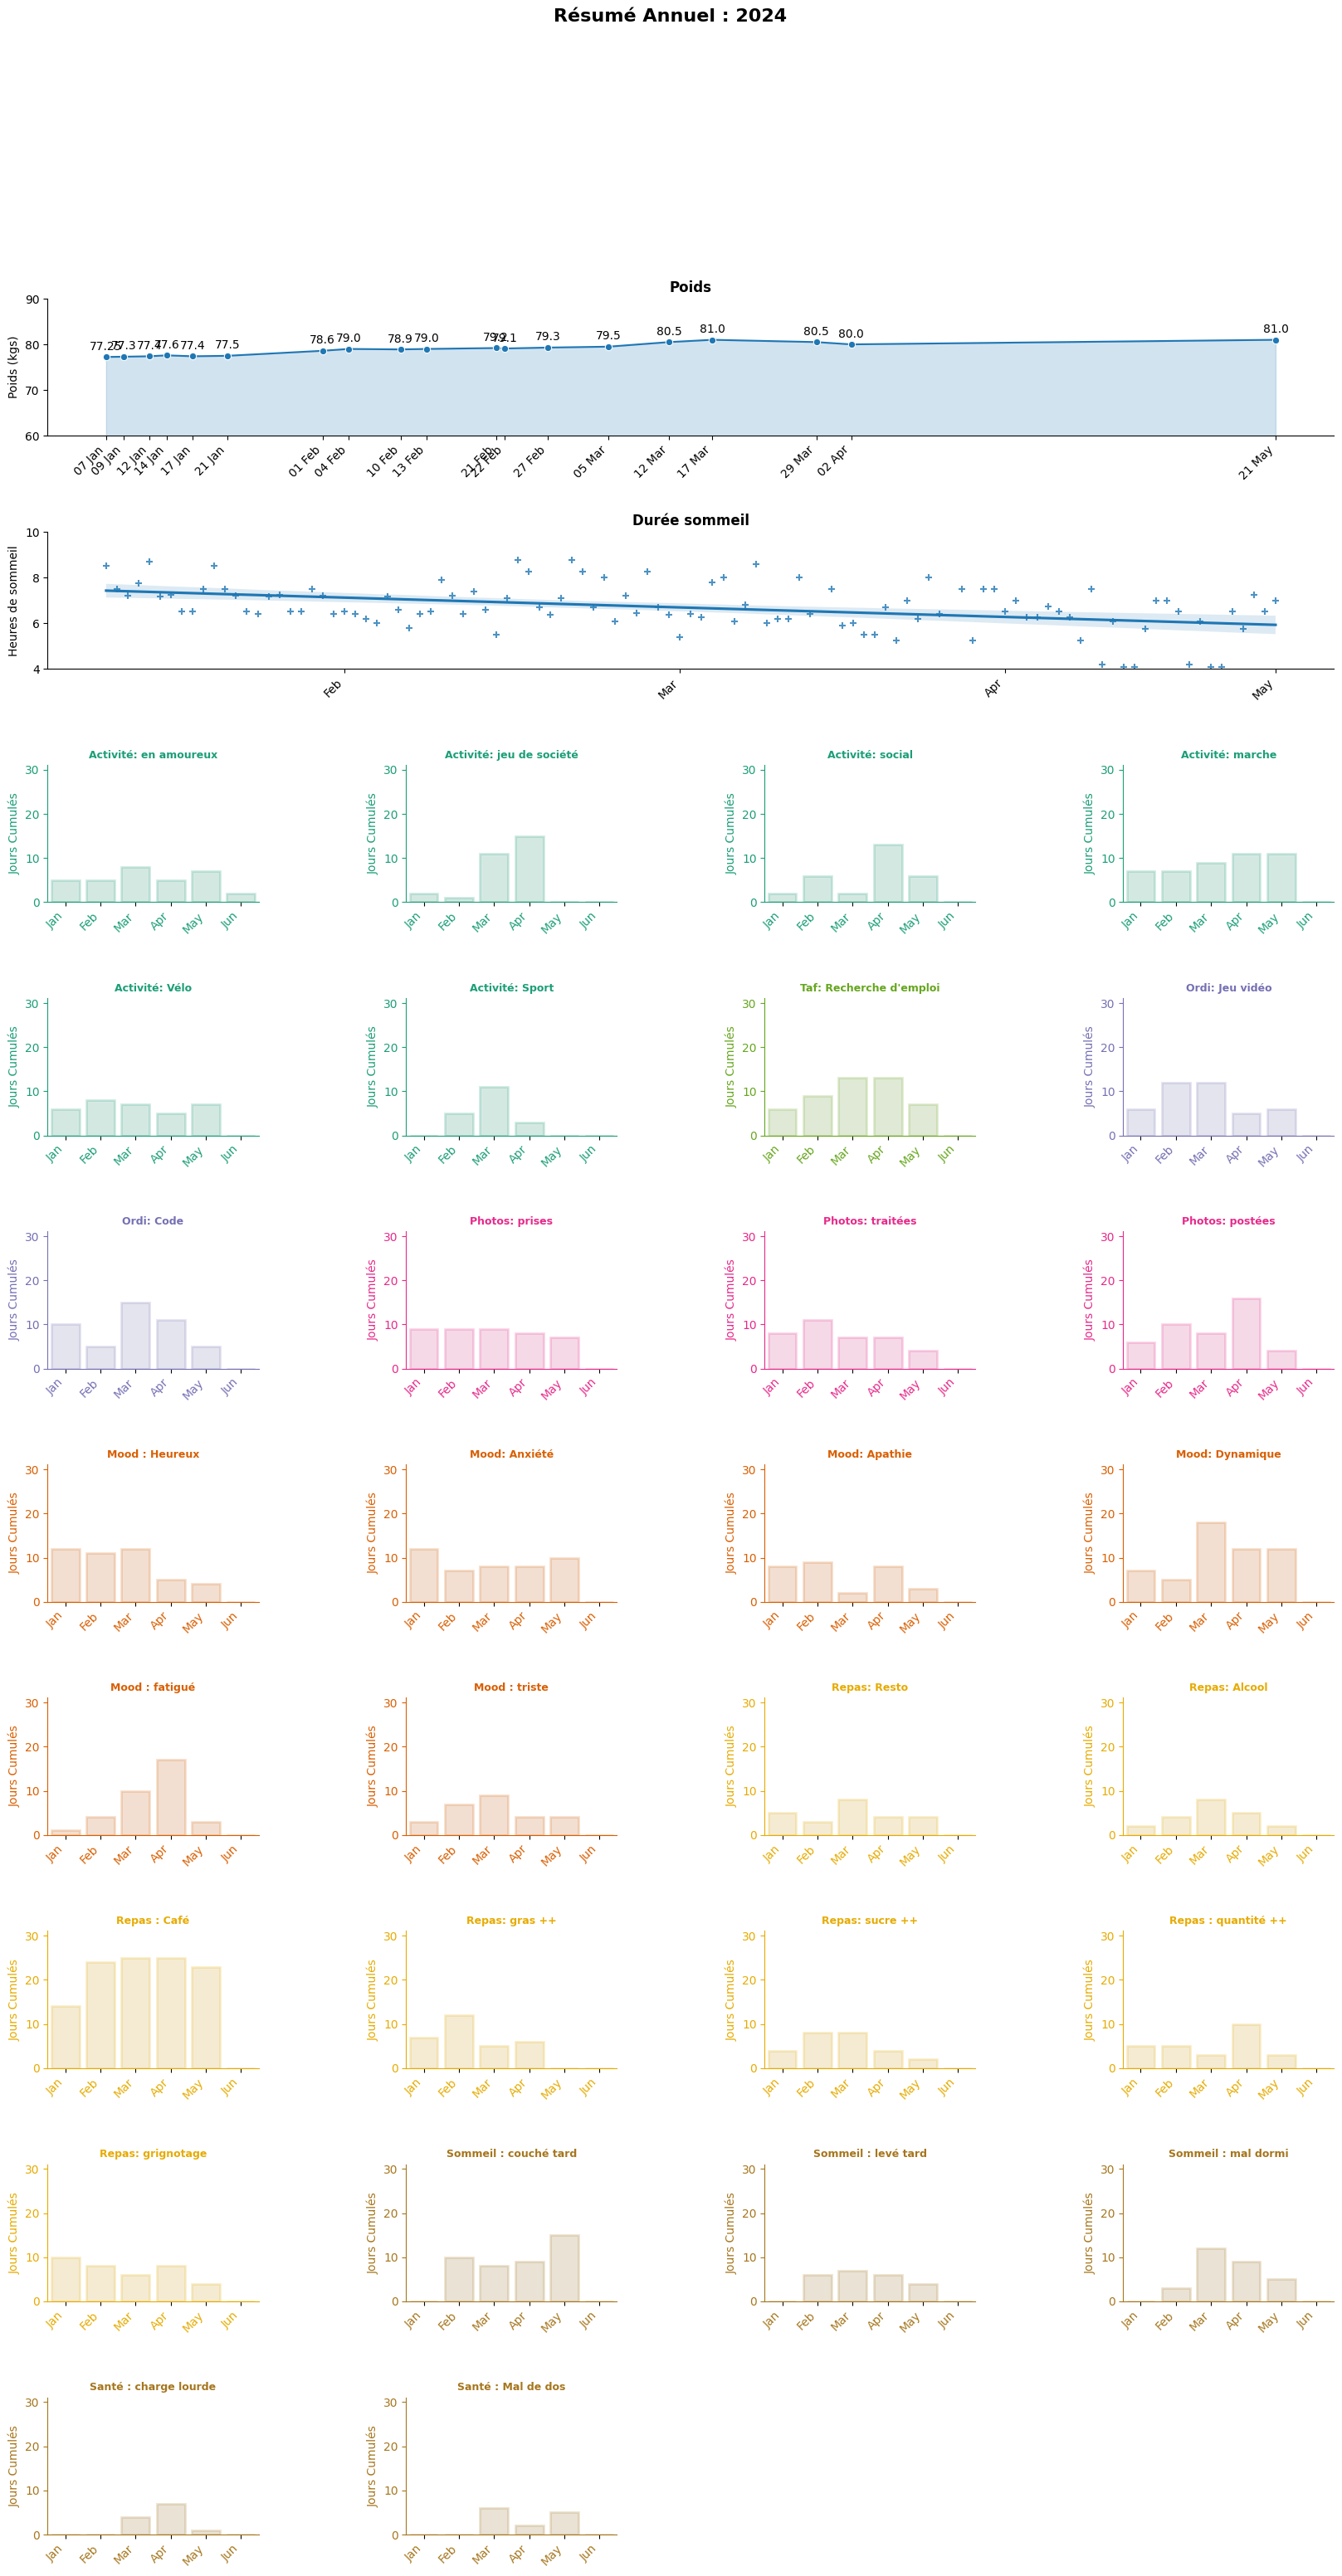

In [218]:
# PLOTTING BY YEAR / MONTHS

columns_nbr = 3
rows_nbr = 3

columns_nbr_year = 4
rows_nbr_year = 10


# Color palette 
# pour plus de couleurs : https://matplotlib.org/stable/gallery/color/named_colors.html
color_palette = sns.color_palette("Dark2")
color_index = 0

# Names of the months
month_names_list = ["janvier", "février", "mars", "avril", "mai", "juin", "juillet", "août", "septembre", "octobre", "novembre","décembre"]



if option_plot_yearly : 
        
    for value in df_yearly.index:
        year = pd.to_datetime(value).year
        print(year)
    
        # Summary for the year
        # config the gridspec
        fig = plt.figure(figsize=(20, 35))
        fig.suptitle(f"Résumé Annuel : {year}", fontsize=16,fontweight="bold" )


        gx = fig.add_gridspec(nrows=rows_nbr_year, ncols=columns_nbr_year, wspace=0.7, hspace=0.7)

        # weight
        df_current_year = df[df["Date"].dt.year == year]

        ax = fig.add_subplot(gx[0, :])
        weight_plot_yearly(ax, df_current_year[["Date", "Poids"]], "Poids")
        
        
        ax = fig.add_subplot(gx[1, :])   
        sleep_plot_yearly(ax, df_current_year[["Date", "Durée sommeil"]], "Durée sommeil")

        counter_col = 0
        counter_row = 2
        #take only the interesting year
        df_yearly_subset = df_monthly[df_monthly.index.year == year]
        for activity in df_yearly_subset.columns : 


            #grouping the colors by activities
            for a in list_of_activities_to_separate:
                if a.lower() in activity.lower():  # Case-insensitive comparison
                    color_index = list_of_activities_to_separate.index(a)
    

            if color_index > len(color_palette)-1 : 
                color_index = 0      
            selected_color = color_palette[color_index]

            #plots
            ay = fig.add_subplot(gx[counter_row, counter_col])
            bar_plot_yearly(ay, df_yearly_subset[[activity]], activity, color =selected_color )
            
            counter_col +=1 
            if counter_col > columns_nbr_year-1 : 
                counter_col = 0
                counter_row +=1 

        plt.show()
else : 
    print("Option désactivée (voir début du notebook)")


#### Monthly View

C:\Users\eties\AppData\Local\Temp\ipykernel_14040\1766122809.py:100: RuntimeWarning: Mean of empty slice
  mean_current_month = np.nanmean(dataframe[variable])
C:\Users\eties\AppData\Local\Temp\ipykernel_14040\1766122809.py:100: RuntimeWarning: Mean of empty slice
  mean_current_month = np.nanmean(dataframe[variable])


Monthly Score:  1
Monthly Score:  0
Monthly Score:  0
Monthly Score:  0
Monthly Score:  1
Monthly Score:  0
Monthly Score:  1


C:\Users\eties\AppData\Local\Temp\ipykernel_14040\1766122809.py:101: RuntimeWarning: Mean of empty slice
  mean_previous_month = np.nanmean(previousmonthdataframe[variable])
C:\Users\eties\AppData\Local\Temp\ipykernel_14040\1766122809.py:101: RuntimeWarning: Mean of empty slice
  mean_previous_month = np.nanmean(previousmonthdataframe[variable])
C:\Users\eties\AppData\Local\Temp\ipykernel_14040\1766122809.py:100: RuntimeWarning: Mean of empty slice
  mean_current_month = np.nanmean(dataframe[variable])
C:\Users\eties\AppData\Local\Temp\ipykernel_14040\1766122809.py:101: RuntimeWarning: Mean of empty slice
  mean_previous_month = np.nanmean(previousmonthdataframe[variable])


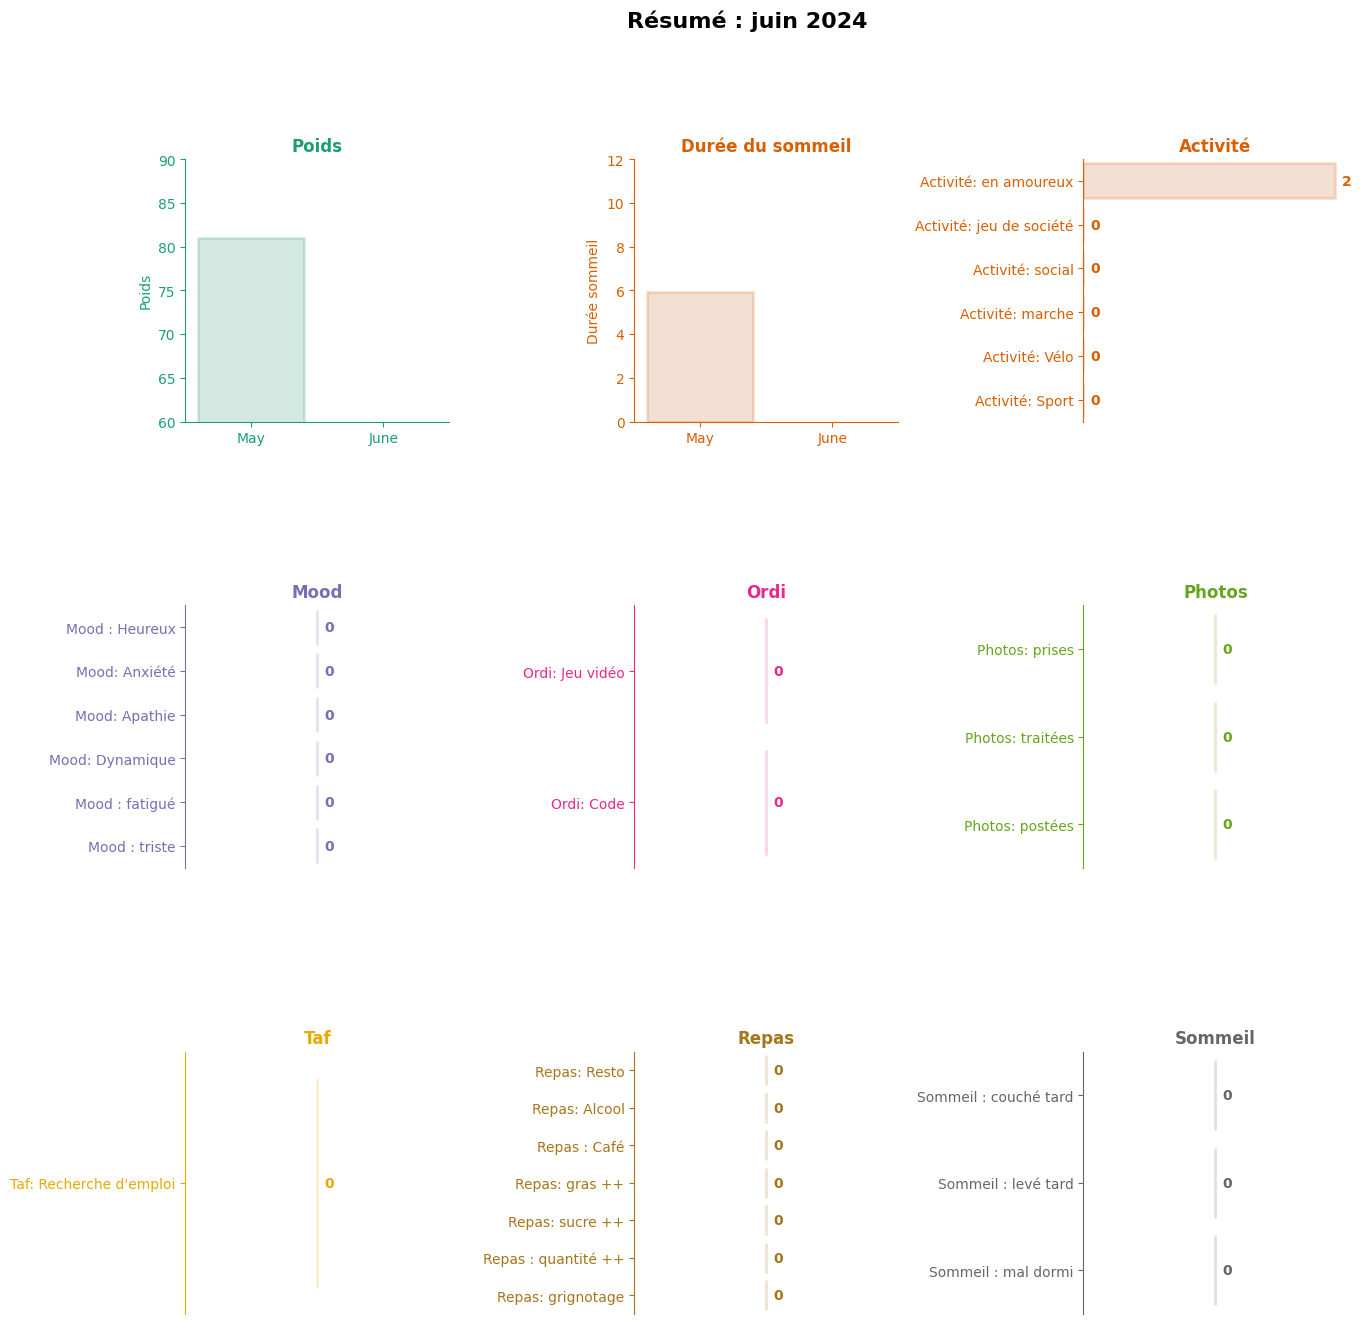

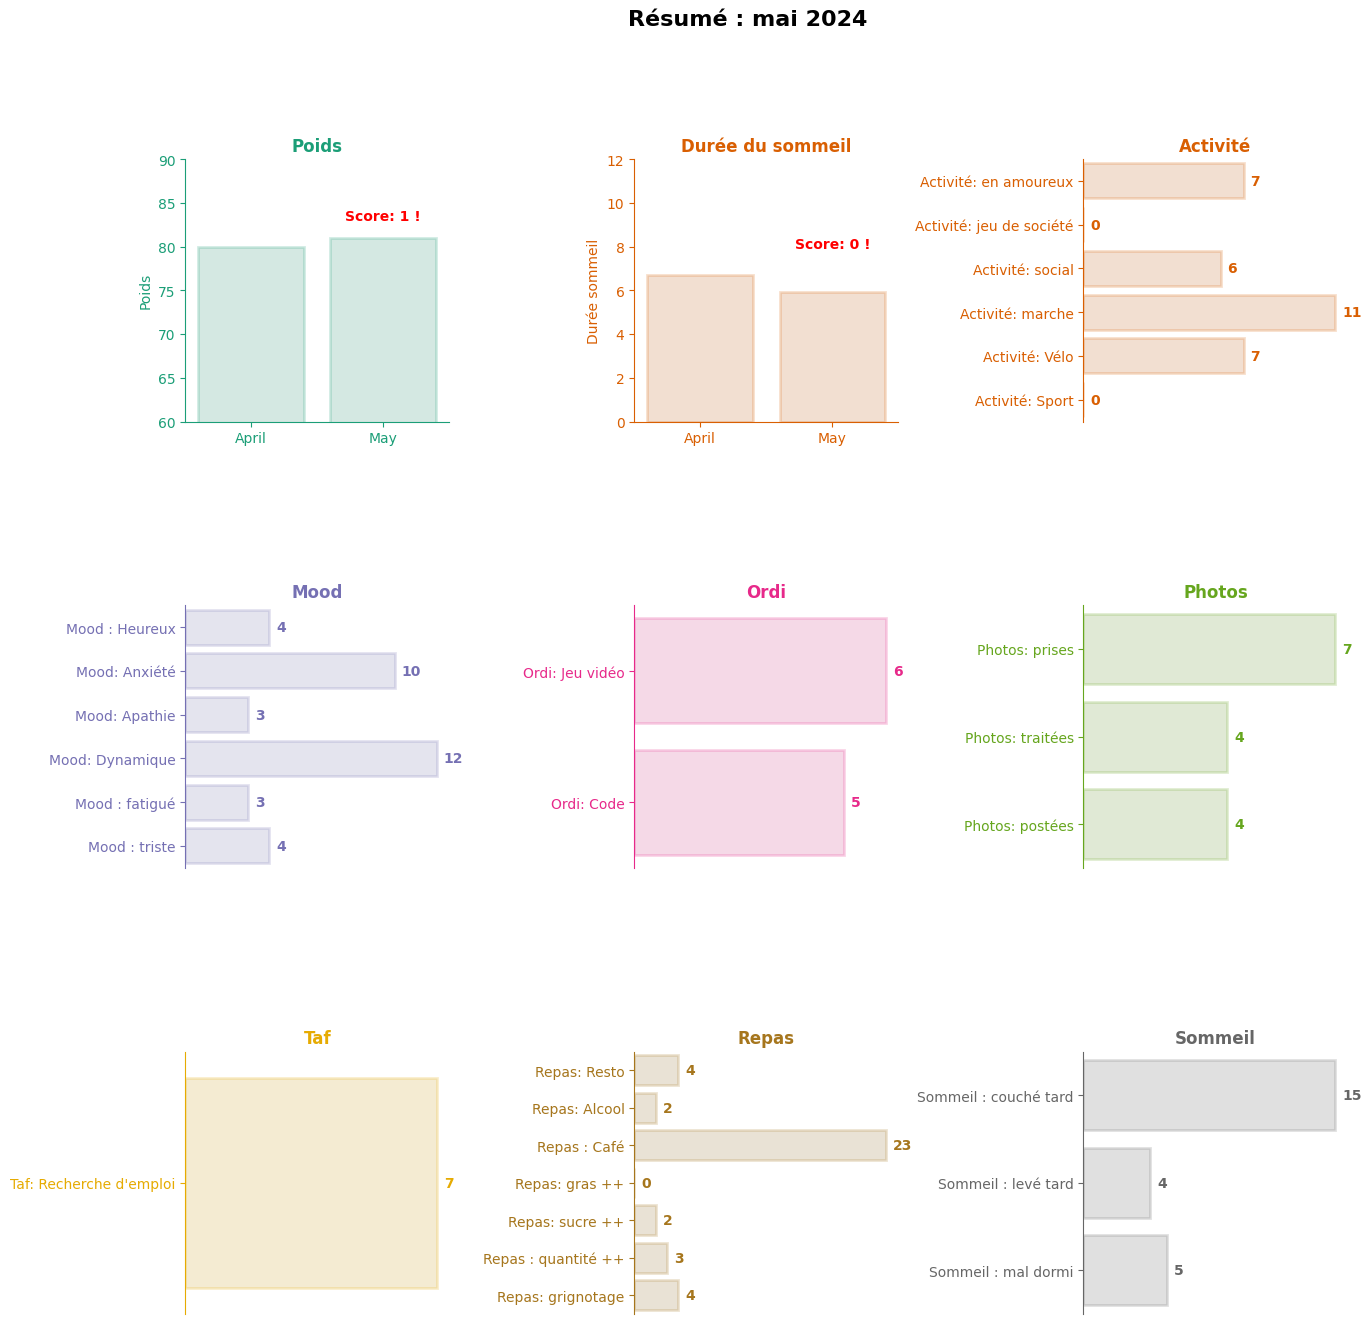

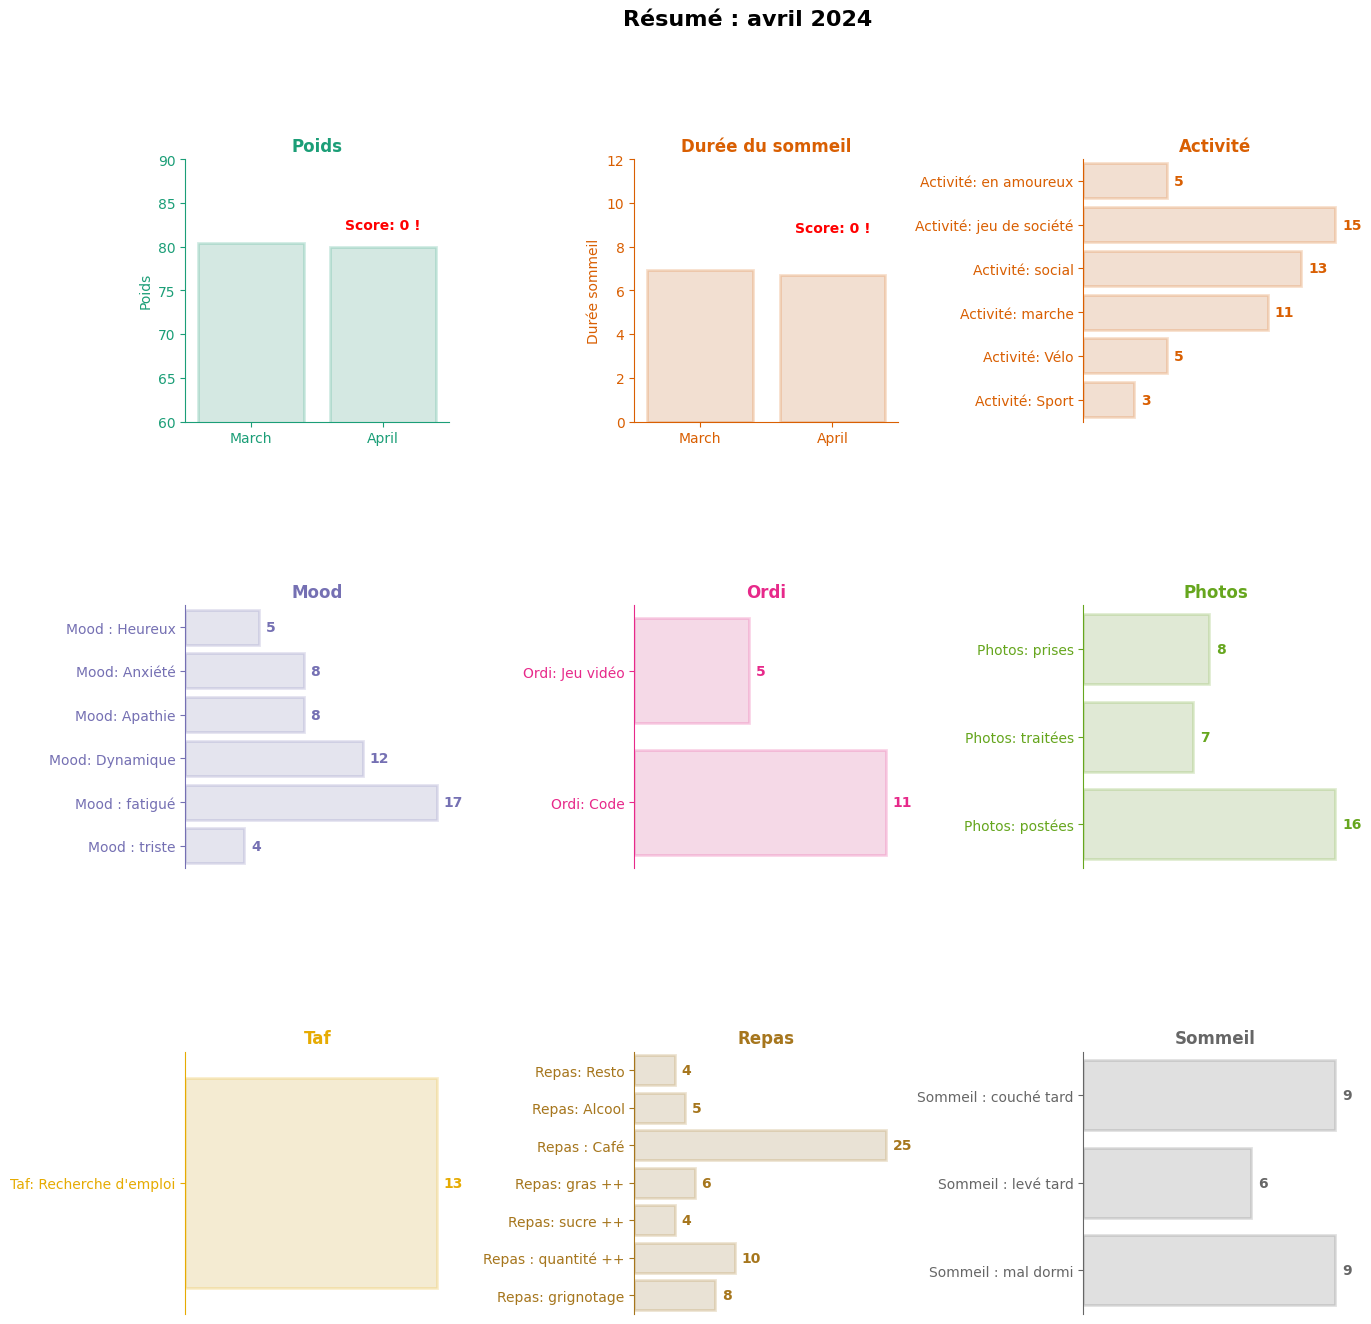

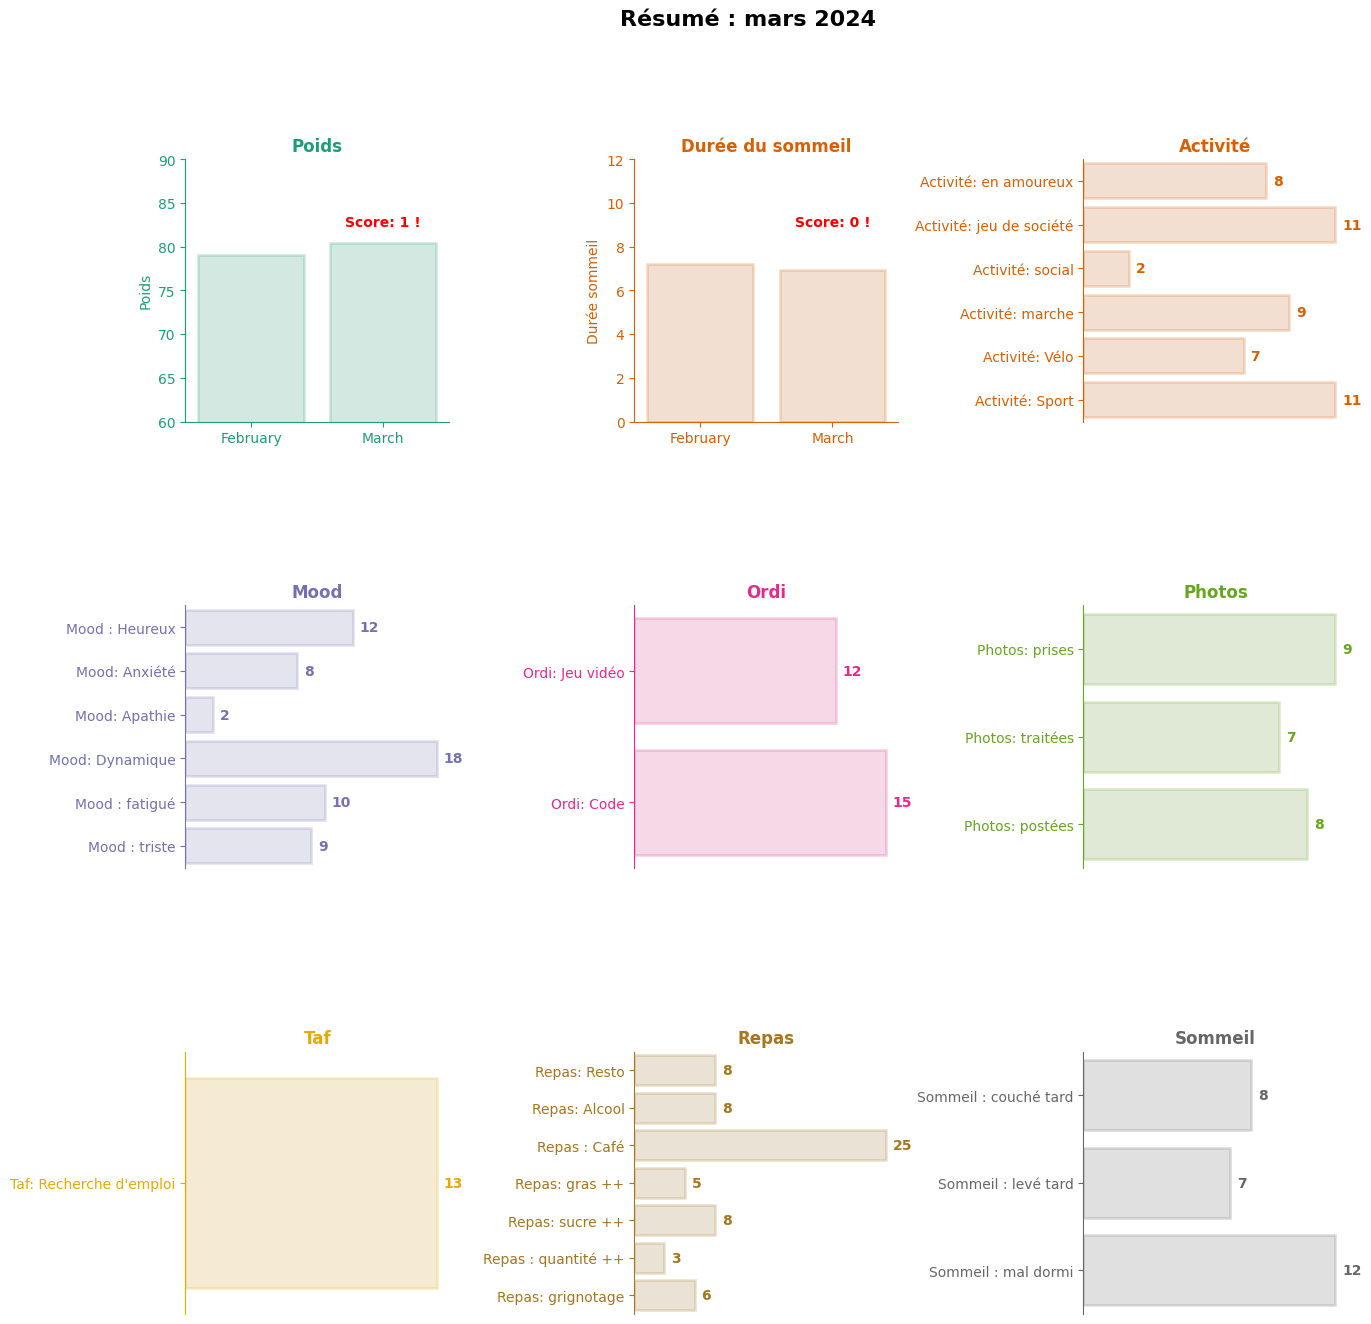

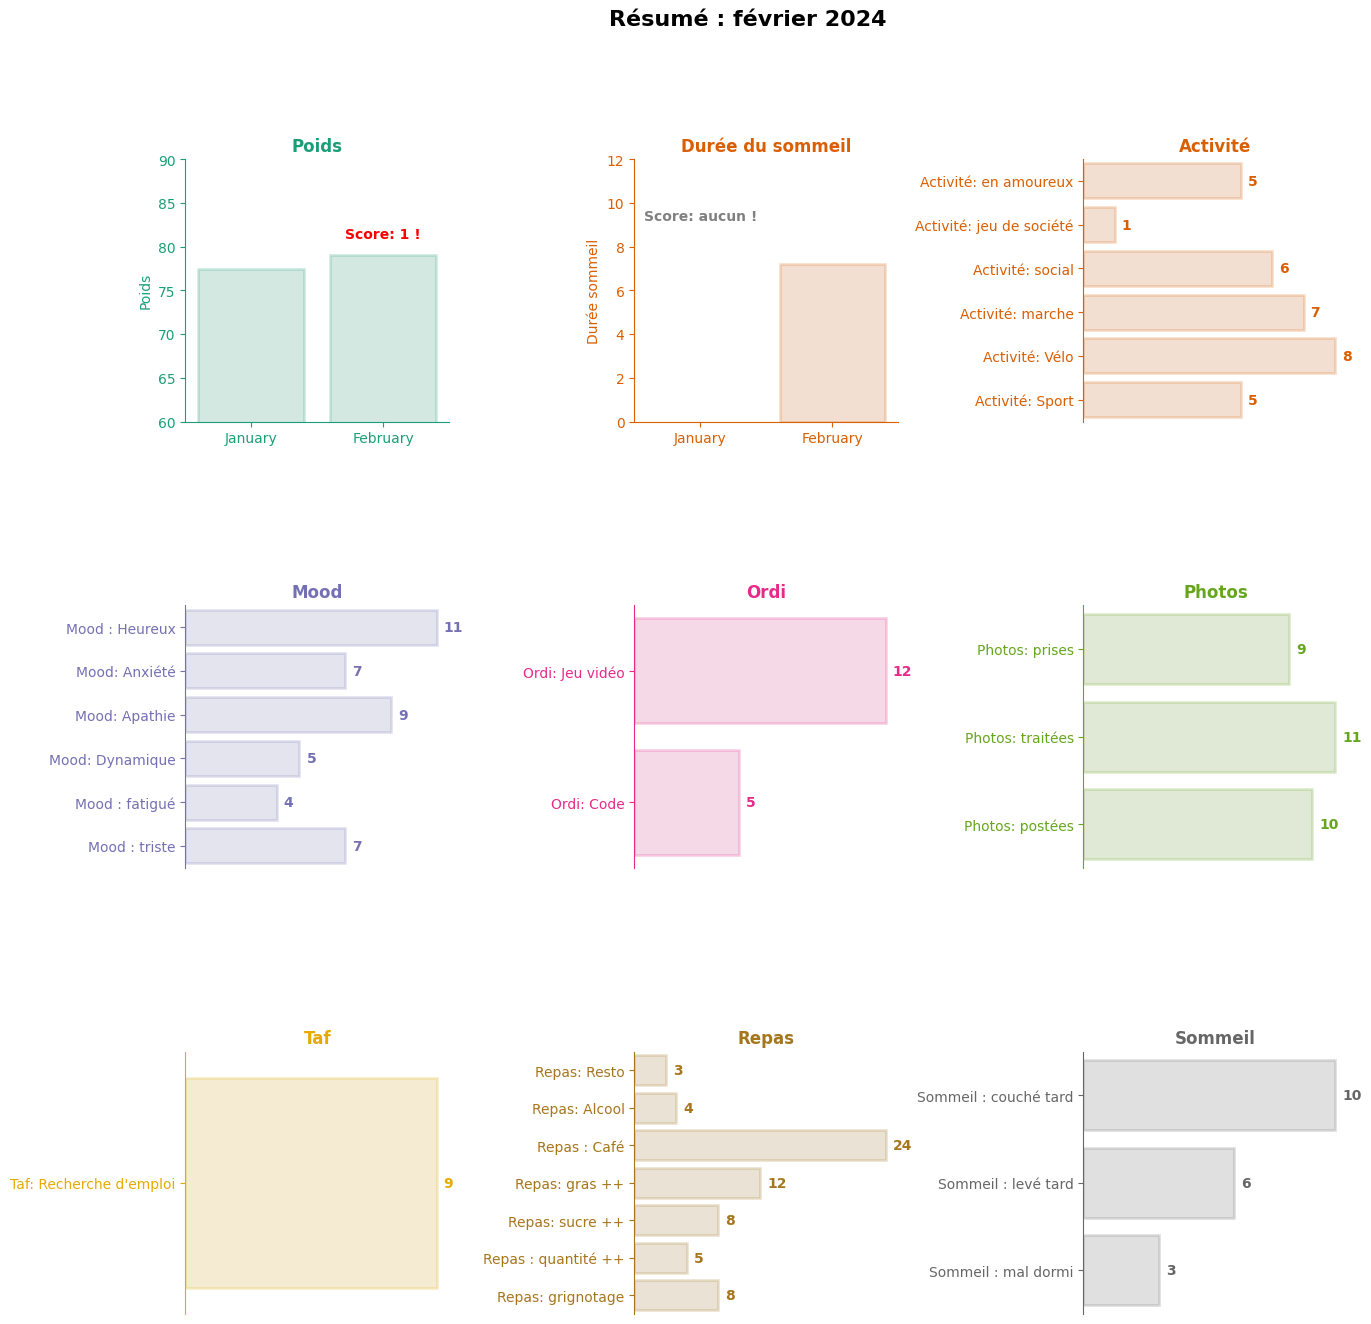

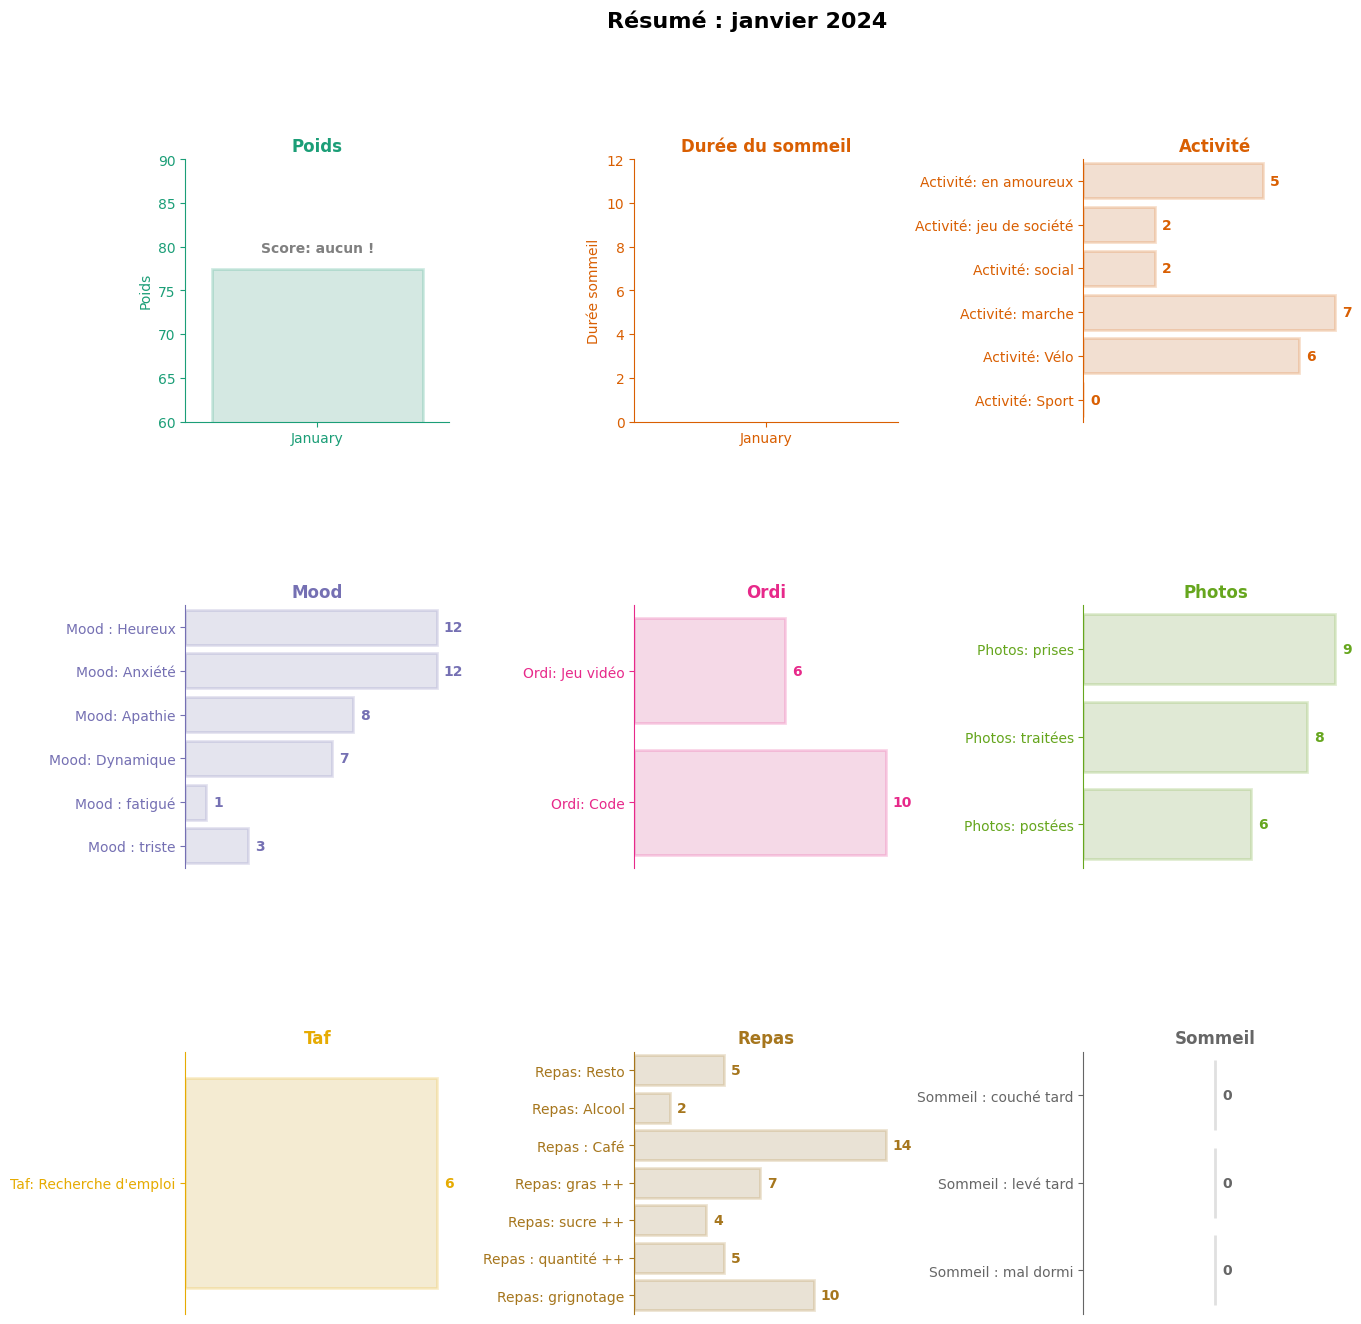

In [219]:
if option_plot_monthly: 
    columns_nbr = 3
    rows_nbr = 3

    for year, month_dataframes in year_dictionnary_by_month.items():

        for month, month_df in month_dataframes.items():
            color_index = 0

            month_name_text = month_names_list[month-1]

            dataframe_without_weight = month_df.drop("Poids", axis=1)

            fig = plt.figure(figsize=(15, 15))
            gs = fig.add_gridspec(nrows=rows_nbr, ncols=columns_nbr, wspace=0.7, hspace=0.7)

            fig.suptitle(f"Résumé : {month_name_text} {year}", fontsize=16, fontweight="bold")

            df_numerics.loc[:, 'Date'] = pd.to_datetime(df_numerics['Date'])
            numerics_current_month = df_numerics[(df_numerics['Date'].dt.month == month) & (df_numerics['Date'].dt.year == year)]
            previous_month_date = pd.to_datetime(f'{year}-{month}-01') - pd.DateOffset(months=1)
            numerics_previous_month = df_numerics[df_numerics['Date'].dt.month == previous_month_date.month]
            
            ax = fig.add_subplot(gs[0, 0])
            numerics_plot_monthly(ax, numerics_current_month, numerics_previous_month, "Poids", color=color_palette[color_index], variable="Poids")

            ax = fig.add_subplot(gs[0, 1])
            numerics_plot_monthly(ax, numerics_current_month, numerics_previous_month, "Durée du sommeil", color=color_palette[color_index + 1], variable="Durée sommeil", lim=(0, 12))

            counter_col = 2
            counter_row = 0
            
            color_index += 1
            
            for item in list_of_activities_to_separate:

                if color_index > len(color_palette) - 1: 
                    color_index = 0      
                selected_color = color_palette[color_index]
            
                current_activity_list = [index for index in dataframe_without_weight.columns if item in index]
                current_activity_list.append("Date")
                
                df_for_activity_subplot = dataframe_without_weight[current_activity_list]

                ay = fig.add_subplot(gs[counter_row, counter_col])
                habits_plot(ay, df_for_activity_subplot, title=item, color=selected_color)
                
                color_index += 1 
                counter_col += 1 
                if counter_col > columns_nbr - 1: 
                    counter_col = 0
                    counter_row += 1 
                
        plt.show()
else: 
    print("Option disabled")

## Calendar View

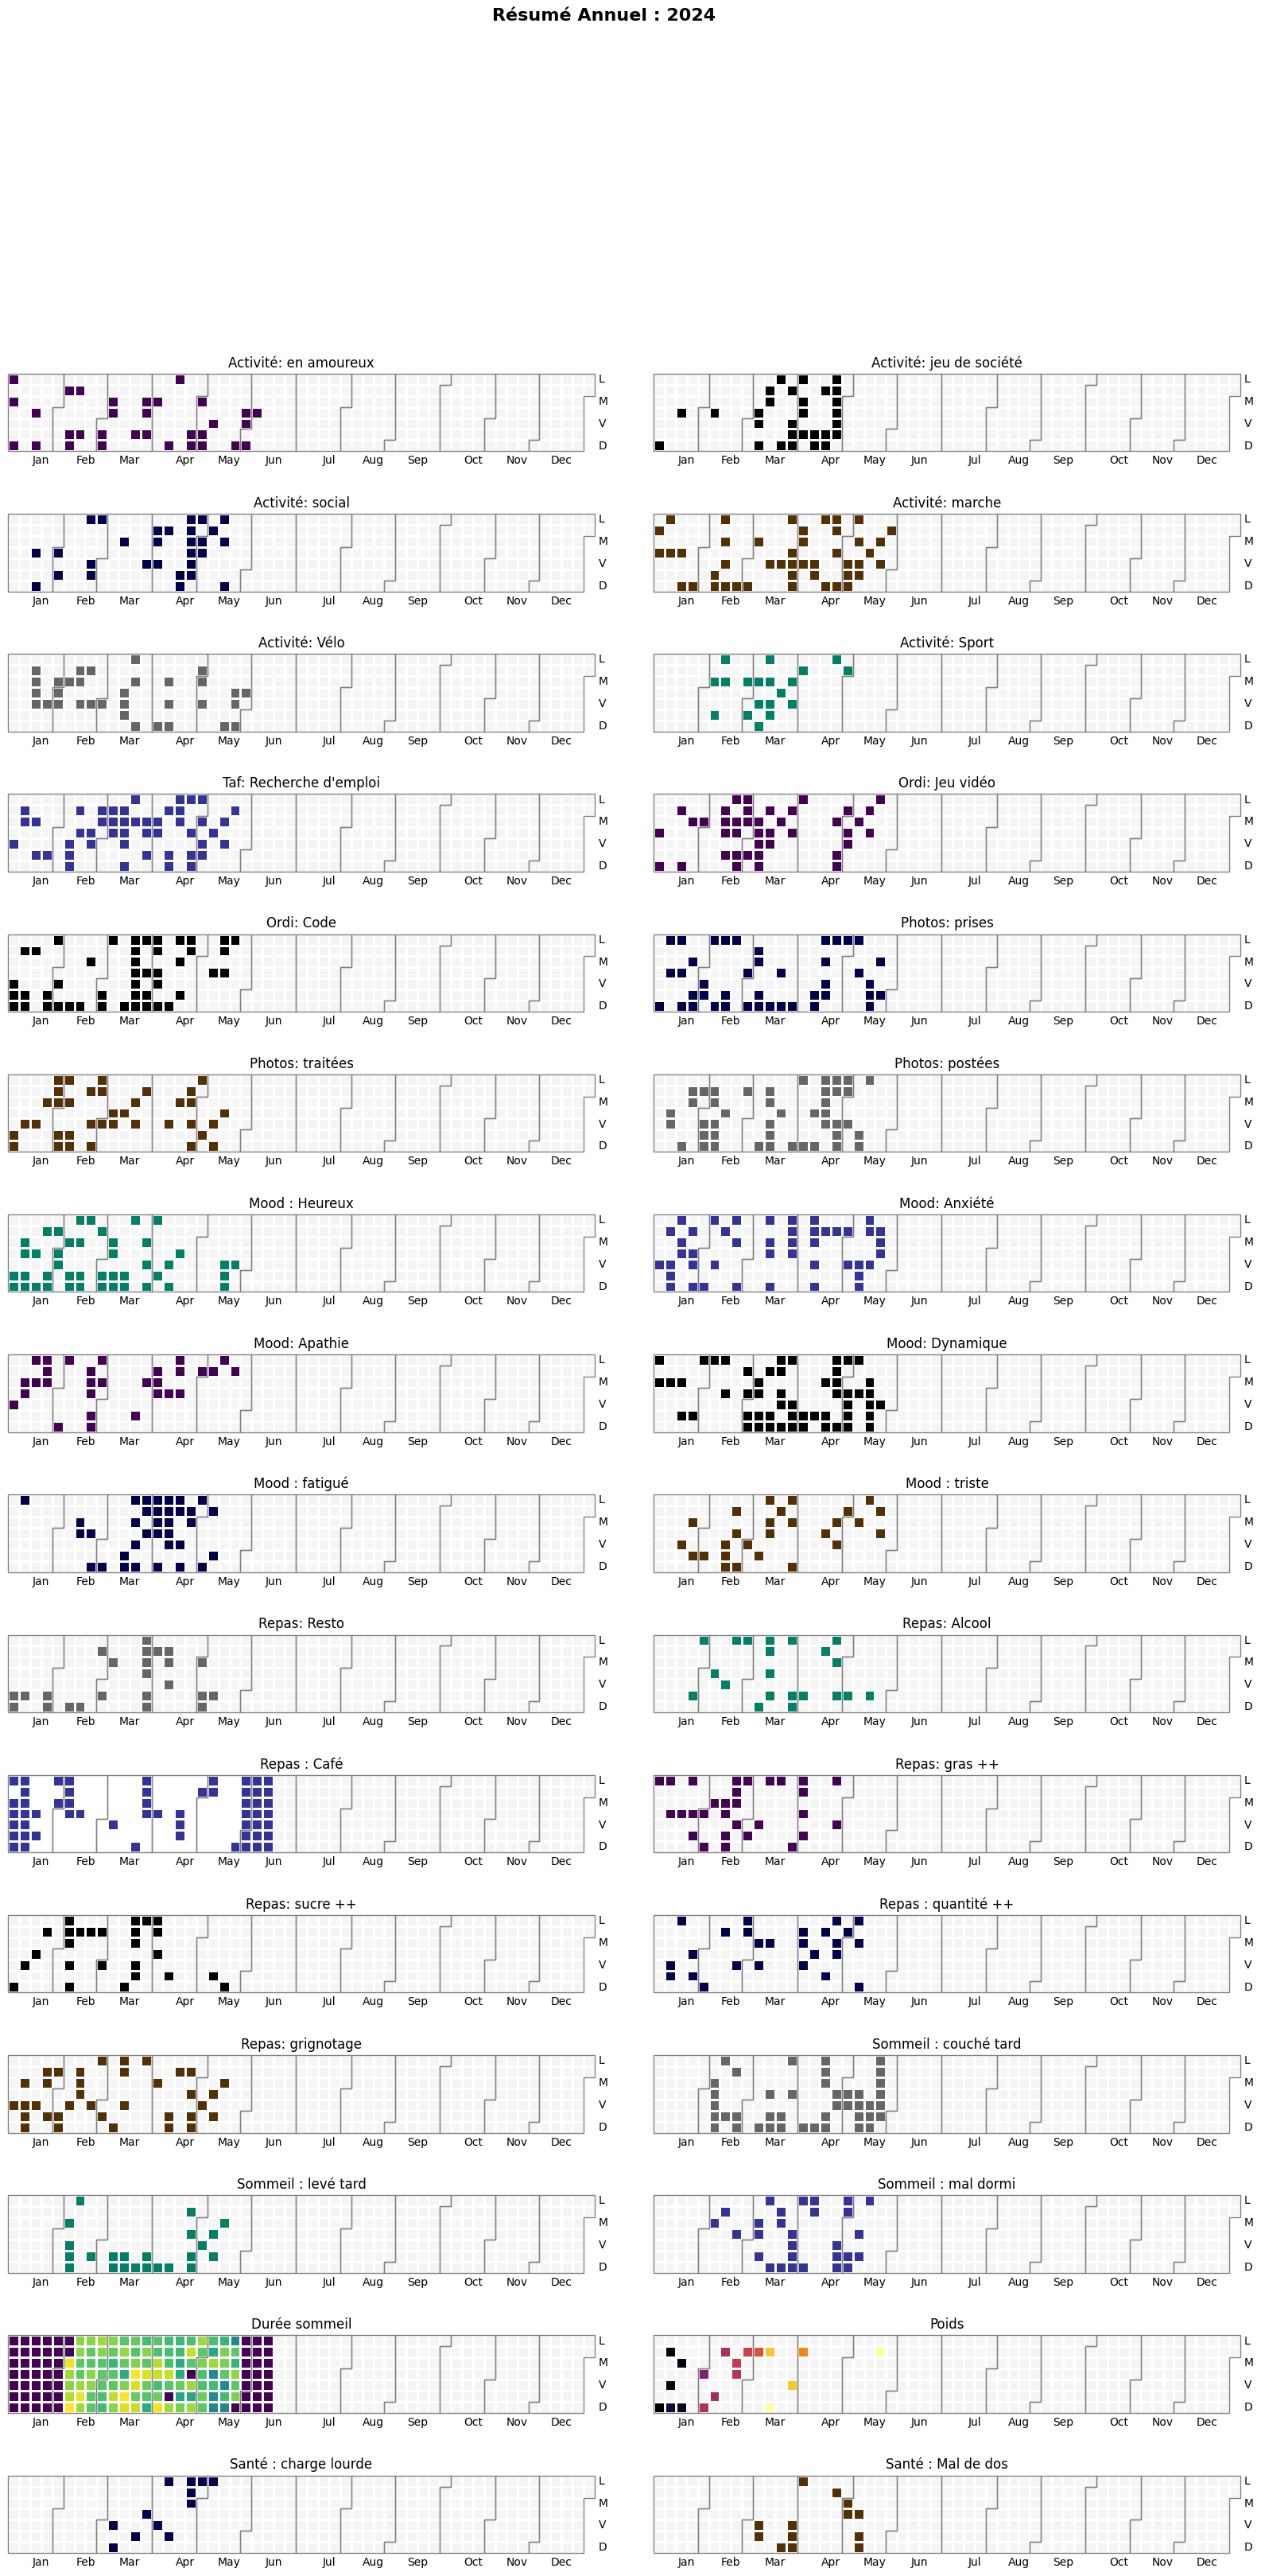

In [220]:
if option_plot_calendar_view:

    import calplot

    columns_nbr_year = 2
    rows_nbr_year = 20

    color_index = 0

    month_names_list = ["janvier", "février", "mars", "avril", "mai", "juin", "juillet", "août", "septembre", "octobre", "novembre", "décembre"]

    list_of_activities_to_separate = ["Activité", "Mood", "Ordi", "Photos", "Taf", "Repas", "Sommeil"]

        
    for value in df_yearly.index:

        year = pd.to_datetime(value).year

        df_current_year = df[df["Date"].dt.year == year]

        df_current_year["Date"] = pd.to_datetime(df_current_year["Date"])
        
        df_current_year.set_index("Date", inplace=True)
    

        fig = plt.figure(figsize=(20, 45))
        fig.suptitle(f"Résumé Annuel : {year}", fontsize=16, fontweight="bold")

        gx = fig.add_gridspec(nrows=rows_nbr_year, ncols=columns_nbr_year, wspace=0.1, hspace=0.5)

        counter_col = 0
        counter_row = 0
        color_palette_list = ["viridis", "inferno", "seismic", "BrBG", "Accent_r", "summer", "terrain"]

        
        for activity in df_current_year.columns: 
            
            personalized_palette = color_palette_list[color_index]
            series_activity = pd.Series(df_current_year[activity].values, name=activity, index=df_current_year.index)

            ay = fig.add_subplot(gx[counter_row, counter_col])
            ay.set_title(activity)

            calplot.yearplot(series_activity, year=year, cmap=personalized_palette, linewidth=1, daylabels='LMMJVSD', dayticks=[0, 2, 4, 6], ax=ay)

            color_index += 1 
            if color_index > len(color_palette_list) - 1:
                color_index = 0
            counter_col += 1 
            if counter_col > columns_nbr_year - 1: 
                counter_col = 0
                counter_row += 1 

        plt.show()

else: 
    print("Option disabled")

## Analysis

### Correlations

                          Activité: en amoureux  Activité: jeu de société  \
Activité: en amoureux              1.000000e+00                  0.059211   
Activité: jeu de société           5.921079e-02                  1.000000   
Activité: social                  -2.101028e-02                  0.291491   
Activité: marche                   1.858196e-01                  0.079390   
Activité: Vélo                    -1.090117e-02                 -0.067253   
Activité: Sport                    1.823331e-02                  0.085550   
Taf: Recherche d'emploi            1.965348e-01                  0.164364   
Ordi: Jeu vidéo                    7.730536e-02                  0.070502   
Ordi: Code                         8.093879e-03                  0.108068   
Photos: prises                     3.500700e-02                  0.063655   
Photos: traitées                  -1.741843e-03                  0.023302   
Photos: postées                   -1.313404e-02                  0.121970   

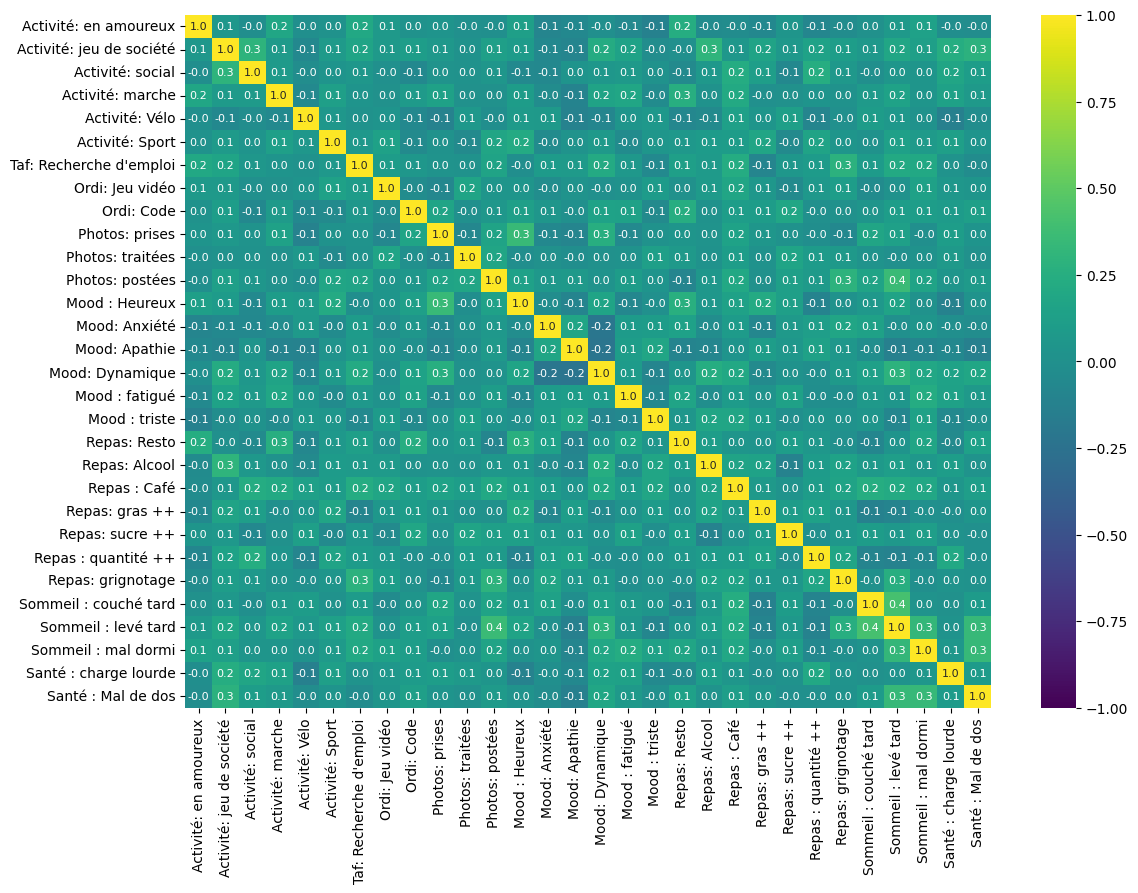

In [221]:
# Creating the correlation matrix


df_for_correlation = df.drop(["Poids", "Durée sommeil", "Date"], axis = 1) # drop wheight and Date


correlation_matrix = df_for_correlation.corr()

# Display the correlation matrix
print(correlation_matrix)

plt.figure(figsize=(13, 9))

annot_kws = {'size': 8}

# Set the font size for the text inside the heatmap
sns.heatmap(correlation_matrix, cmap='viridis', fmt=".1f", annot=True, annot_kws=annot_kws, vmin = -1, vmax = 1)

plt.show()






#### Top Correlations

In [222]:

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_lower_abs_correlations(df, n=5):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

print(f"TOP CORRELATION :\n\n{get_top_abs_correlations(correlation_matrix, 7)}\n\n\n")

print(f"TOP INVERSE CORRELATION :\n\n{get_lower_abs_correlations(correlation_matrix, 7)}\n\n\n")



TOP CORRELATION :

Sommeil : couché tard  Sommeil : levé tard    0.584465
Photos: prises         Mood : Heureux         0.525058
Sommeil : mal dormi    Santé : Mal de dos     0.523502
Sommeil : levé tard    Santé : Mal de dos     0.492909
Mood: Dynamique        Sommeil : levé tard    0.470297
Photos: postées        Sommeil : levé tard    0.468583
Sommeil : levé tard    Sommeil : mal dormi    0.436258
dtype: float64



TOP INVERSE CORRELATION :

Mood: Apathie        Mood: Dynamique         -0.550622
Mood: Anxiété        Mood: Dynamique         -0.502212
Mood: Apathie        Sommeil : levé tard     -0.430787
Repas : quantité ++  Sommeil : levé tard     -0.416763
Mood: Apathie        Santé : Mal de dos      -0.403134
Repas: gras ++       Sommeil : couché tard   -0.402195
                     Sommeil : levé tard     -0.378440
dtype: float64





### Clustering and Dendrogram

C:\Users\eties\AppData\Local\Temp\ipykernel_14040\2027644875.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dist_matrix, method='ward')


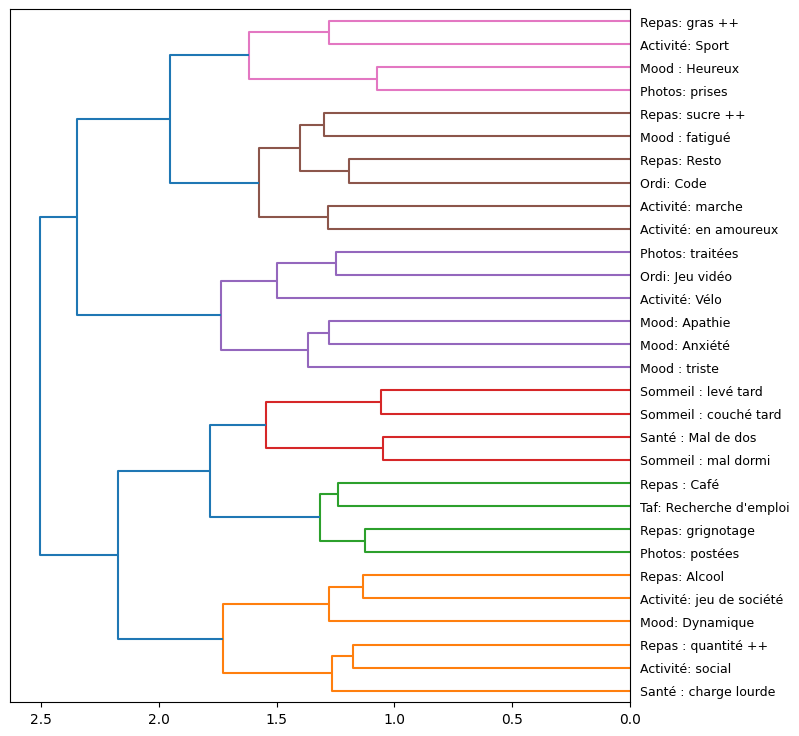

In [223]:

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster import hierarchy


# Perform hierarchical clustering on the correlation matrix
# Use 'ward' linkage method and Euclidean distance metric
dist_matrix = 1 - correlation_matrix
linkage_matrix = linkage(dist_matrix, method='ward')

dataframe_transposed = df_for_correlation.transpose()

activity_names = dataframe_transposed.index.tolist()


# Cut the dendrogram at a certain height to create clusters
# The height can be chosen based on the shape of the dendrogram
# or using a clustering validation metric
from scipy.cluster.hierarchy import cut_tree
clusters = cut_tree(linkage_matrix, height=0.2).reshape(-1,)

dataframe_transposed = df_for_correlation.transpose()

# Add the cluster labels to the original DataFrame
dataframe_transposed['cluster'] = clusters

# Plot the dendrogram
plt.figure(figsize=(8, 9))
dendrogram(linkage_matrix, leaf_rotation=0., labels = activity_names, leaf_font_size=9.,orientation='left')


plt.show()
